In [1]:
import requests
from bs4 import BeautifulSoup
import urllib
import time
import re
import numpy as np
import pandas as pd

### Functions steps

1. **[v]** get_next_page_link(soup) -> url
* **[v]** get_current_links(soup) -> list
* **[v]** get_links(soup) -> list
* **[v]** get_stats_for_movie(soup) -> list
    * **[v]** user rating
    * **[v]** number of votes
    * **[v]** metacritic score
    * **[v]** number of review
    * **[v]** movie length
    * **[v]** box office
* **[v]** get_all_stats(dict) -> pd.DataFrame

In [2]:
url = 'https://www.imdb.com/search/title/?title_type=feature&release_date=2019-01-01,2019-12-31&countries=fr&languages=fr'

In [3]:
def get_next_page_link(soup):
    links = soup.find_all('a', attrs={'class': 'next-page'})
    if len(links) == 0:
        return None
    else:
        return links[0]['href']

In [4]:
def get_current_links(soup):
    movie_headers = soup.find_all('h3', attrs={'class':'lister-item-header'})
    movie_links = {el.find('a').text: el.find('a')['href'] for el in movie_headers}
    return movie_links

<br>
<br>
<br>

In [5]:
# Пример применения пакета urllib
print(url)
urllib.parse.urljoin(url, '/title/tt8613070/')

https://www.imdb.com/search/title/?title_type=feature&release_date=2019-01-01,2019-12-31&countries=fr&languages=fr


'https://www.imdb.com/title/tt8613070/'

<br>
<br>
<br>

In [6]:
def get_all_links(url):
    headers = {'Accept-Language': 'en',
          'X-FORWARDED-FOR': '2.21.184.0'}
    
    all_movies_links = {}
    
    while True:
        response = requests.get(url, headers=headers)
        assert response.status_code == 200
        soup = BeautifulSoup(response.text)
        movie_links = get_current_links(soup)
        movie_links = {movie:
                       urllib.parse.urljoin(url, movie_link) 
                       for (movie, movie_link) 
                       in movie_links.items()}
        all_movies_links.update(movie_links)
        
        link = get_next_page_link(soup)
        if not link:
            return all_movies_links
        url = urllib.parse.urljoin(url, link)
        time.sleep(1)

In [7]:
temp = get_all_links(url)

In [8]:
len(temp)

329

**329 elements like in IMDb page**

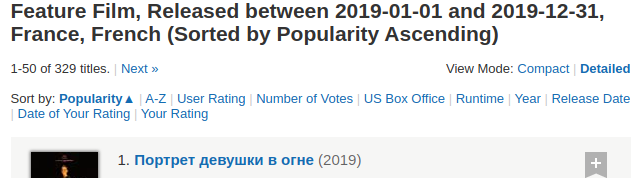

* **[v]** user rating
* **[v]** number of votes
* **[v]** metacritic score
* **[v]** number of review
* **[v]** movie length
* **[v]** box office

In [9]:
def get_stats_for_movie(soup):
    try:
        ratingValue = soup.find('span', attrs={'itemprop': 'ratingValue'})
        if ratingValue:
            ratingValue = float(ratingValue.text)
    except:
        ratingValue = np.nan
    
    try:
        ratingCount = soup.find('span', attrs={'itemprop': 'ratingCount'})
        if ratingCount:
            ratingCount = int(ratingCount.text.replace(',', ''))
    except:
        ratingCount = np.nan
    
    try:
        metacriticScore = soup.find('div', attrs={'class': 'metacriticScore'})
        if metacriticScore:
            metacriticScore = int(metacriticScore.find('span').text)
    except:
        metacriticScore = np.nan
        
    try:
        reviews = soup.find('div', text=re.compile("\s*Reviews\s*"))
        if reviews:
            num_of_reviews = reviews.parent.find_all('a')
            user_reviews = int(re.match(re.compile('\d+'), num_of_reviews[0].text).group())
            critic_reviews = int(re.match(re.compile('\d+'), num_of_reviews[1].text).group())
    except:
        user_reviews, critic_reviews = np.nan, np.nan
        
    try:
        minutes = int(re.findall(re.compile('\d'), soup.find('time', attrs={'datetime': True})['datetime'])[0])
    except:
        minutes = np.nan
        
    try:
        money = int(soup.find(text=re.compile("Cumulative Worldwide Gross:")).parent.parent.text.split('$')[-1]
                .strip().replace(',', ''))
    except:
        money = np.nan
        
    return [ratingValue, ratingCount, metacriticScore, user_reviews, critic_reviews, minutes, money]

In [10]:
url = temp['Portrait of a Lady on Fire']

In [11]:
url

'https://www.imdb.com/title/tt8613070/'

In [12]:
headers = {'Accept-Language': 'en',
          'X-FORWARDED-FOR': '2.21.184.0'}

response = requests.get(url, headers=headers)
print(response.status_code)

soup = BeautifulSoup(response.text)

200


In [13]:
def get_all_stats(all_movie_links, verbose=False):
    data = []
    columns = ['title', 'ratingValue', 'ratingCount', 'metacriticScore', 
               'user_reviews', 'critic_reviews', 'minutes', 'money']
    
    start = time.time()
    done = 0
    
    for movie, url in all_movie_links.items():
        response = requests.get(url, headers)
        if response.status_code == 200:
            soup = BeautifulSoup(response.text)
            movie_stat = get_stats_for_movie(soup)
            data_row = [movie] + movie_stat
            data.append(data_row)
            time.sleep(1)
            if verbose:
                done += 1
                print(f'Done with {done} movies.',
                      f'There are {len(all_movie_links)- done} more left',
                      f'Spend {time.time() - start:.1f} seconds')
        else:
            data.append([movie] + [np.nan] * 7)
            time.sleep(5)
    return pd.DataFrame(data=data, columns=columns)